In [257]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
import soundfile as sf
from sklearn.model_selection import train_test_split
from keras.models import Model
from keras.layers import Input, Conv2D, Conv2DTranspose
import soundfile as sf
import glob
from datetime import datetime

In [258]:
# Directory where your .wav files are located
directory = '../raw_data/musicnet/musicnet/test_data_split/'

# Create a file path list for all .wav files in the directory
file_paths = list(glob.glob(directory + '/*.wav'))

# Print the file paths
# for file_path in file_paths:
#     print(file_path)

In [259]:
# Load the .wav files and generate spectrograms
def load_data(file_paths):
    spectrograms = []
    for file_path in file_paths:
        audio, sr = librosa.load(file_path, sr=44100, mono=True)
        spectrogram = librosa.feature.melspectrogram(y=audio, sr=sr)
        spectrogram = librosa.power_to_db(spectrogram)
        spectrograms.append(spectrogram)
    return spectrograms

spectrograms = load_data(file_paths)
len(spectrograms)

45

In [260]:
# Split the data into training and testing sets
X_train, X_test = train_test_split(spectrograms, test_size=0.2, random_state=42)
# we will need these later on for de-normalization
TEST_MIN = np.min(X_test)
TEST_MAX = np.max(X_test)
# Normalize the spectrograms and reshape them
X_train = (X_train - np.min(X_train)) / (np.max(X_train) - np.min(X_train))
X_test = (X_test - np.min(X_test)) / (np.max(X_test) - np.min(X_test))

X_train = np.expand_dims(X_train, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)

### functional API to build the autoencoder: 

In [263]:
X_train[0].shape

(128, 2584, 1)

In [299]:
# Define the encoder model
input_shape = X_train[0].shape

input_layer = Input(shape=input_shape)
encoder = Conv2D(16, (3, 3), activation='relu', padding='same')(input_layer)
encoder = Conv2D(8, (3, 3), activation='relu', padding='same')(encoder)

encoder_model = Model(input_layer, encoder)

# Define the decoder model
decoder_input = Input(shape=encoder_model.output_shape[1:])
decoder = Conv2DTranspose(8, (3, 3), activation='relu', padding='same')(decoder_input)
decoder = Conv2DTranspose(16, (3, 3), activation='relu', padding='same')(decoder)
decoder = Conv2DTranspose(1, (3, 3), activation='sigmoid', padding='same')(decoder)

decoder_model = Model(decoder_input, decoder)

# Combine the encoder and decoder to create the autoencoder
autoencoder_input = Input(shape=input_shape)
encoded = encoder_model(autoencoder_input)
decoded = decoder_model(encoded)

autoencoder = Model(autoencoder_input, decoded)
autoencoder.compile(optimizer='adam', loss='logcosh')

In [300]:
encoder_model.summary()

Model: "model_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_40 (InputLayer)       [(None, 128, 2584, 1)]    0         
                                                                 
 conv2d_29 (Conv2D)          (None, 128, 2584, 16)     160       
                                                                 
 conv2d_30 (Conv2D)          (None, 128, 2584, 8)      1160      
                                                                 
Total params: 1,320
Trainable params: 1,320
Non-trainable params: 0
_________________________________________________________________


In [301]:
decoder_model.summary()

Model: "model_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_41 (InputLayer)       [(None, 128, 2584, 8)]    0         
                                                                 
 conv2d_transpose_30 (Conv2D  (None, 128, 2584, 8)     584       
 Transpose)                                                      
                                                                 
 conv2d_transpose_31 (Conv2D  (None, 128, 2584, 16)    1168      
 Transpose)                                                      
                                                                 
 conv2d_transpose_32 (Conv2D  (None, 128, 2584, 1)     145       
 Transpose)                                                      
                                                                 
Total params: 1,897
Trainable params: 1,897
Non-trainable params: 0
________________________________________________________

In [302]:
autoencoder.summary()

Model: "model_33"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_42 (InputLayer)       [(None, 128, 2584, 1)]    0         
                                                                 
 model_31 (Functional)       (None, 128, 2584, 8)      1320      
                                                                 
 model_32 (Functional)       (None, 128, 2584, 1)      1897      
                                                                 
Total params: 3,217
Trainable params: 3,217
Non-trainable params: 0
_________________________________________________________________


## using functions to build encoder, decoder and autoencoder: 

In [303]:
# from tensorflow.keras import layers, models

# # Function to build the encoder
# def build_encoder(latent_space):
#     input_shape = X_train[0].shape  # Specify the input shape of your data
#     input_layer = layers.Input(shape=input_shape)
#     encoder = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(input_layer)
#     encoder = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(encoder)
#     encoder = layers.Flatten()(encoder)
#     latent_output = layers.Dense(latent_space, activation='relu')(encoder)
#     encoder_model = models.Model(input_layer, latent_output)
#     return encoder_model

# # Function to build the decoder
# def build_decoder(latent_space):
#     decoder_input = layers.Input(shape=(latent_space,))
#     decoder = layers.Dense(units=np.prod(latent_shape[1:]), activation='relu')(decoder_input)
#     decoder = layers.Reshape(target_shape=latent_shape[1:])(decoder)
#     decoder = layers.Conv2DTranspose(8, (3, 3), activation='relu', padding='same')(decoder)
#     decoder = layers.Conv2DTranspose(16, (3, 3), activation='relu', padding='same')(decoder)
#     decoder_output = layers.Conv2DTranspose(1, (3, 3), activation='sigmoid', padding='same')(decoder)
#     decoder_model = models.Model(decoder_input, decoder_output)
#     return decoder_model

# # Function to build the autoencoder
# def build_autoencoder(encoder, decoder):
#     autoencoder_input = layers.Input(shape=encoder.input_shape[1:])
#     encoded = encoder(autoencoder_input)
#     decoded = decoder(encoded)
#     autoencoder = models.Model(autoencoder_input, decoded)
#     autoencoder.compile(optimizer='adam', loss='mse')
#     return autoencoder

# # Specify the latent space dimension
# latent_space = 16

# # Build the encoder, decoder, and autoencoder
# encoder = build_encoder(latent_space)
# decoder = build_decoder(latent_space)
# autoencoder = build_autoencoder(encoder, decoder)

In [304]:
# from kapre.losses import *
# spectrogram_loss = SpectrogramLoss()
# perceptual_loss = PerceptualLoss()

In [305]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

es = EarlyStopping(patience = 3, restore_best_weights=True)

# Get the current date and time for naming our model respectively
date_time_str = datetime.now().strftime("%Y-%m-%d_%H")

# save the best model using checkpoint callback 
checkpoint = ModelCheckpoint(f"autoencoder_{date_time_str}.h5", save_best_only=True)

# Train the autoencoder model
history = autoencoder.fit(X_train, X_train, 
                          epochs=100, batch_size=16, 
                          validation_data=(X_test, X_test),
                          callbacks= [es, checkpoint])

Epoch 1/100
3/3 [==============================] - 16s 5s/step - loss: 0.0429 - val_loss: 0.0412
Epoch 2/100
3/3 [==============================] - 15s 5s/step - loss: 0.0418 - val_loss: 0.0395
Epoch 3/100
3/3 [==============================] - 15s 5s/step - loss: 0.0406 - val_loss: 0.0381
Epoch 4/100
3/3 [==============================] - 16s 5s/step - loss: 0.0395 - val_loss: 0.0366
Epoch 5/100
3/3 [==============================] - 17s 5s/step - loss: 0.0381 - val_loss: 0.0348
Epoch 6/100
3/3 [==============================] - 16s 5s/step - loss: 0.0362 - val_loss: 0.0324
Epoch 7/100
3/3 [==============================] - 18s 6s/step - loss: 0.0335 - val_loss: 0.0290
Epoch 8/100
3/3 [==============================] - 17s 5s/step - loss: 0.0298 - val_loss: 0.0248
Epoch 9/100
3/3 [==============================] - 17s 5s/step - loss: 0.0252 - val_loss: 0.0194
Epoch 10/100
3/3 [==============================] - 17s 5s/step - loss: 0.0198 - val_loss: 0.0135
Epoch 11/100
3/3 [===========

### To load an already trained model

In [ ]:
# from tensorflow.keras.models import load_model
# # Load an existing autoencoder model
# autoencoder = load_model('autoencoder_2023-06-06_15.h5')

### Predict using the model

In [306]:
# Generate reconstructed spectrograms using the trained autoencoder
reconstructed_X_test = autoencoder.predict(X_test)
reconstructed_X_train = autoencoder.predict(X_train)

2/2 [==============================] - 6s 786ms/step


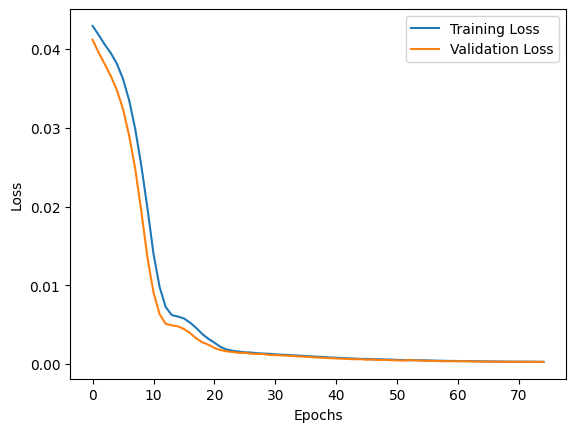

In [307]:
# Plot the training and validation loss curves
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Visualize some original vs. autoencoded spectrograms

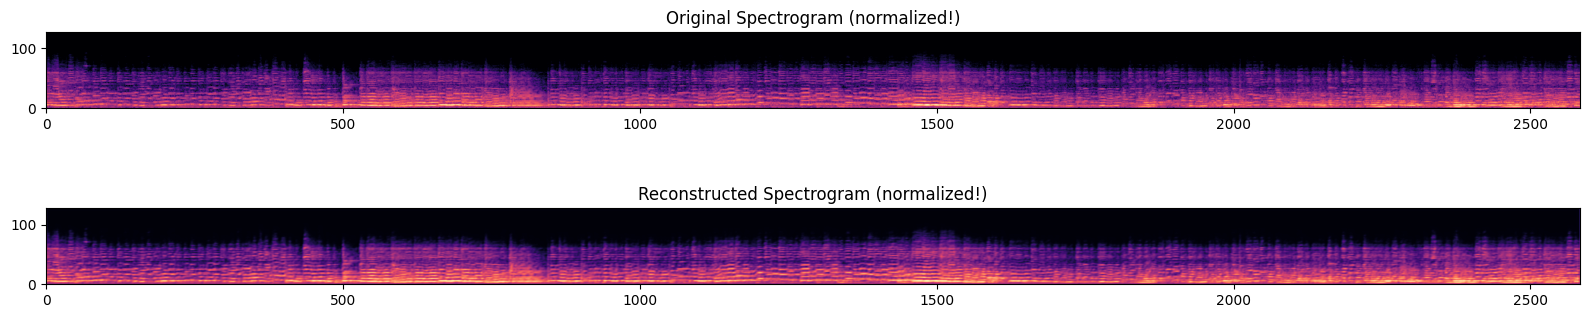

In [308]:
# Visualize the original and reconstructed spectrograms
index = 0
plt.figure(figsize=(16, 4))
plt.subplot(2, 1, 1)
plt.title('Original Spectrogram (normalized!)')
plt.imshow(X_test[index].squeeze(), cmap='magma', origin='lower')

plt.subplot(2, 1, 2)
plt.title('Reconstructed Spectrogram (normalized!)')
plt.imshow(reconstructed_X_test[index].squeeze(), cmap='magma', origin='lower')

plt.tight_layout()
plt.show()

### reverse transform the reconstructed_spectrograms:

In [309]:
print(X_train.min(), X_train.max())
print(reconstructed_X_train.min(), reconstructed_X_train.max())

0.0 1.0
0.021634948 0.9043496


In [310]:
print(X_test.min(), X_test.max())
print(reconstructed_X_test.min(), reconstructed_X_test.max())

0.0 1.0
0.02168935 0.90396327


In [284]:
spectrogram = reconstructed_X_test[0]
spectrogram.shape

(128, 2584, 1)

In [285]:
# #Remove the extra dimension added by np.expand_dims:
# spectrogram = np.squeeze(spectrogram, axis=-1)
#De-normalize the spectrograms back into their original range:
spectrogram_denorm = spectrogram * (TEST_MAX - TEST_MIN) + TEST_MIN
# Reshape the spectrograms back to their original shape:
# spectrogram_denorm = np.reshape(spectrogram_denorm, X_test.shape)
# spectrogram_denorm = np.expand_dims(spectrogram_denorm, axis=-1)
spectrogram_denorm.shape 

(128, 2584, 1)

In [287]:
print(TEST_MIN, TEST_MAX)
print(spectrogram_denorm.min(), spectrogram_denorm.max())

-57.336655 36.08081
-48.45101 25.238503


In [ ]:
# # De-normalize reconstructed_spectrograms back into X_test ranges
# reconstructed_spectrograms_denorm = reconstructed_spectrograms * (np.max(X_test) - np.min(X_test)) + np.min(X_test)

In [ ]:
# # Assuming the sampling rate and hop length used to generate the spectrograms
# sampling_rate = 44100
# #duration = 30  # Desired duration in seconds
# #hop_length = int(duration * sampling_rate)
# hop_length = 520 

# # Inverse transform the spectrograms to obtain the audio signals
# reconstructed_audios = []
# for spectrogram in reconstructed_spectrograms_denorm:
#     spectrogram = np.squeeze(spectrogram)
#     spectrogram = librosa.db_to_power(spectrogram)
#     audio = librosa.feature.inverse.mel_to_audio(spectrogram, sr=sampling_rate, hop_length=hop_length) 
#     reconstructed_audios.append(audio)

# # Save the audio signals as .wav files
# for i, audio in enumerate(reconstructed_audios[0:1]):
#     output_path = f'reconstructed_audio_{i}.wav'
#     sf.write(output_path, audio, sampling_rate)


In [296]:
# file_path = file_paths[0]
# file_path
# audio, sr = librosa.load(file_path, sr=44100, mono=True)
# spectrogram = librosa.feature.melspectrogram(y=audio, sr=sr)
# spectrogram = librosa.power_to_db(spectrogram)

In [ ]:
X_test[0].shape

In [311]:
sampling_rate = 44100
hop_length = 520
i = 2
spectrogram = reconstructed_X_test[i]
spectrogram_denorm = spectrogram * (TEST_MAX - TEST_MIN) + TEST_MIN
spectrogram_denorm = spectrogram_denorm.squeeze()
spectrogram_denorm.shape

spectrogram_rev = librosa.db_to_power(spectrogram_denorm)

reconstructed_audio = librosa.feature.inverse.mel_to_audio(spectrogram_rev, sr=sampling_rate, hop_length=hop_length)
output_path = f'reconstructed_audio_{i}_.wav'
sf.write(output_path, reconstructed_audio, sampling_rate)